# Kaggle Top Spotify songs from 2010-2019

https://www.kaggle.com/leonardopena/top-spotify-songs-from-20102019-by-year

## Objectiu

Utilitzar la base de dades de Kaggle del Top Spotify songs from 2010-2019 per entrenar un classificador que ens digui a quin percentatge de popularitat pot pèrtanyer una nova canço de spotify segons les seves dades. És a dir, pel nostre case el target serà l'atribut 'pop'.

## Continguts

1. EDA i Preprocessing
* Anàlisi de tamany i tipologia de dades
* Anàlisi i modificació del target
* Encoding de categòriques
* Valoració de correlacions
* Normalització
* Equilibració de classes

2. Metric Selection
* Selecció de la millor mètrica
* Visualització de ROC/AUC

3. Model Selection i Crossvalidation
* Selecció del millor model
* Cerca d'hiperparàmetres

4. Anàlisi Final

Primer de tot, importem llibreries essencials, a més de les dades i observem que s'han importat correctament. Ho veiem a continuació:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.preprocessing import LabelEncoder

df=pd.read_csv("top10s.csv", encoding='latin1')

print(df.dtypes)
print(df.head())

Unnamed: 0     int64
title         object
artist        object
top genre     object
year           int64
bpm            int64
nrgy           int64
dnce           int64
dB             int64
live           int64
val            int64
dur            int64
acous          int64
spch           int64
pop            int64
dtype: object
   Unnamed: 0                 title      artist        top genre  year  bpm  \
0           1      Hey, Soul Sister       Train       neo mellow  2010   97   
1           2  Love The Way You Lie      Eminem  detroit hip hop  2010   87   
2           3               TiK ToK       Kesha        dance pop  2010  120   
3           4           Bad Romance   Lady Gaga        dance pop  2010  119   
4           5  Just the Way You Are  Bruno Mars              pop  2010  109   

   nrgy  dnce  dB  live  val  dur  acous  spch  pop  
0    89    67  -4     8   80  217     19     4   83  
1    93    75  -5    52   64  263     24    23   82  
2    84    76  -3    29   71  200 

## 1. EDA i Preprocessing

### - Anàlisi de tamany i tipologia de dades

Mirem quantes mostres i quants atributs té la nostre base de dades i què significa cadascun.

In [2]:
print("Número de mostres:", df.shape[0])
print("Número d'atributs:", df.columns.shape[0])

Número de mostres: 603
Número d'atributs: 15


Cada atribut significa:

-Unnamed: ID

-title: Song's title

-artist: Song's artist

-top genre: The genre of the track

-year: Song's year in the Billboard

-bpm: Beats.Per.Minute - The tempo of the song

-nrgy: Energy- The energy of a song - the higher the value, the more energtic. song

-dnce: Danceability - The higher the value, the easier it is to dance to this song

-dB: Loudness..dB.. - The higher the value, the louder the song

-live: Liveness - The higher the value, the more likely the song is a live recording

-val: Valence - The higher the value, the more positive mood for the song

-dur: Length - The duration of the song

-acous: Acousticness.. - The higher the value the more acoustic the song is

-spch: Speechiness - The higher the value the more spoken word the song contains

-pop: Popularity- The higher the value the more popular the song is

Com que la columna id no té nom, de moment li assignem.

In [3]:
df.rename(columns={'Unnamed: 0': 'id'}, inplace=True)

El tipus d'atributs que tenim són:

In [4]:
print(df.dtypes)

id            int64
title        object
artist       object
top genre    object
year          int64
bpm           int64
nrgy          int64
dnce          int64
dB            int64
live          int64
val           int64
dur           int64
acous         int64
spch          int64
pop           int64
dtype: object


-Categòrics: title, artist i top genre
    
-Numèrics: id, year, bpm, nrgy, dnce, dB, live, val, dur, acous, spch i pop

Tenim NaNs a les dades?

In [5]:
print(df.isna().sum())

id           0
title        0
artist       0
top genre    0
year         0
bpm          0
nrgy         0
dnce         0
dB           0
live         0
val          0
dur          0
acous        0
spch         0
pop          0
dtype: int64


Sorprenentment no tenim NaNs a les dades, així que no hem de tractar res en aquest cas.

### - Anàlisi i modificació del target

En el nostre cas el target és la columna 'pop', anem a fer un anàlisi més profund.

In [6]:
print(df['pop'].value_counts(), "\n")
print(df['pop'].unique(), "\n")

# Mostrem les primeres files
print("Target abans de convertir en intervals:")
print(df['pop'].head())

# Creem 10 categories (0 a 9) dividint uniformement el rang de la columna 'pop'
df['pop'] = pd.cut(df['pop'], bins=10, labels=False)

# Mostrem les primeres files per verificar
print("\nTarget després de convertir en intervals:")
print(df['pop'].head())

pop
72    33
78    27
73    26
76    24
65    23
      ..
48     1
27     1
35     1
7      1
39     1
Name: count, Length: 71, dtype: int64 

[83 82 80 79 78 77 76 73 72 71 70 69 68 66 65 64 63 62 61 59 58 57 56 55
 52 49 33  0 81 75 74 67 60 54 50 46 38 31 28 27 25  7 88 85 51 45 43 42
 41 36 35 86 44 37 30 84 47 39 34 18 53 48 29 87 99 97 96 95 93 92 90] 

Target abans de convertir en intervals:
0    83
1    82
2    80
3    79
4    78
Name: pop, dtype: int64

Target després de convertir en intervals:
0    8
1    8
2    8
3    7
4    7
Name: pop, dtype: int64


Hem optat per discretitzar el target en 10 intervals de manera que els valors de la columna 'pop' poden anar de 0 a 9:
- 0: [0, 1, 2,..., 9]
- 1: [10, 11, 12,.., 19]
- 2: [20, 21, 22,.., 29]
- 3: [30, 31, 32,.., 39]
- 4: [40, 41, 42,.., 49]
- 5: [50, 51, 52,.., 59]
- 6: [60, 61, 62,.., 69]
- 7: [70, 71, 72,.., 79]
- 8: [80, 81, 82,.., 89]
- 9: [90, 91, 92,.., 99]

### - Encoding de categòriques

Anem a analitzar una mica més les variables categòriques. Analitzem quines cançons es repeteixen perquè apareixen en anys diferents i mirem si l'artista i popularitat coincideixen.

In [7]:
# Contem quantes vegades es repeteix cada títol
frequencia_titol = df['title'].value_counts()

# Filtrem els títols que es repeteixen més d'una vegada
titols_repetits = frequencia_titol[frequencia_titol > 1].index

# Filtrem les files que corresponen a aquests titols repetits
files_repetides = df[df['title'].isin(titols_repetits)]

# Mostrem les files
print(files_repetides[['title', 'artist', 'pop']].sort_values(by='title'))

                                               title             artist  pop
239  A Little Party Never Killed Nobody (All We Got)             Fergie    6
178  A Little Party Never Killed Nobody (All We Got)             Fergie    6
398                                        All I Ask              Adele    7
473                                        All I Ask              Adele    7
95           Castle Walls (feat. Christina Aguilera)               T.I.    4
48           Castle Walls (feat. Christina Aguilera)               T.I.    4
301                                          Company      Justin Bieber    7
396                                          Company      Justin Bieber    7
548                                       First Time               Kygo    7
474                                       First Time               Kygo    7
295                                            Hello              Adele    7
50                                             Hello     Martin Solveig    0

Provem de mirar quants artistes diferents tenim:

In [8]:
print(df['artist'].value_counts())

artist
Katy Perry             17
Justin Bieber          16
Rihanna                15
Maroon 5               15
Lady Gaga              14
                       ..
Iggy Azalea             1
5 Seconds of Summer     1
Michael Jackson         1
Disclosure              1
Daddy Yankee            1
Name: count, Length: 184, dtype: int64


Provem de mirar quants gèneres diferents tenim:

In [9]:
print(df['top genre'].value_counts())
print(df['top genre'].nunique())

top genre
dance pop                    327
pop                           60
canadian pop                  34
barbadian pop                 15
boy band                      15
electropop                    13
british soul                  11
big room                      10
canadian contemporary r&b      9
neo mellow                     9
art pop                        8
complextro                     6
hip pop                        6
australian dance               6
atl hip hop                    5
australian pop                 5
edm                            5
permanent wave                 4
latin                          4
hip hop                        4
colombian pop                  3
tropical house                 3
brostep                        2
downtempo                      2
electronic trap                2
belgian edm                    2
escape room                    2
folk-pop                       2
electro                        2
indie pop                      2


In [10]:
df['top genre'] = df['top genre'].apply(
    lambda x: 'pop' if 'pop' in x else ('hip hop' if 'hip hop' in x else x)
)
genre_counts = df['top genre'].value_counts()
df['top genre'] = df['top genre'].apply(
    lambda x: 'other' if genre_counts[x] < 5 else x
)

print(df['top genre'].value_counts())

top genre
pop                          485
other                         33
boy band                      15
hip hop                       14
british soul                  11
big room                      10
neo mellow                     9
canadian contemporary r&b      9
complextro                     6
australian dance               6
edm                            5
Name: count, dtype: int64


In [11]:
# Convertim totes les columnes categòriques a valors numèrics amb un label encoder
for col in df[['title', 'artist', 'top genre']]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [12]:
print(df['top genre'].nunique())
print(df['top genre'].unique())

11
[ 8  7 10  1  3  9  2  5  0  4  6]


In [13]:
print(df)

      id  title  artist  top genre  year  bpm  nrgy  dnce  dB  live  val  dur  \
0      1    202     174          8  2010   97    89    67  -4     8   80  217   
1      2    298      49          7  2010   87    93    75  -5    52   64  263   
2      3    502      89         10  2010  120    84    76  -3    29   71  200   
3      4     41      94         10  2010  119    92    70  -4     8   71  295   
4      5    252      19         10  2010  109    84    64  -5     9   43  221   
..   ...    ...     ...        ...   ...  ...   ...   ...  ..   ...  ...  ...   
598  599    158     113         10  2019  104    66    61  -7    20   16  176   
599  600    109      46         10  2019   95    79    75  -6     7   61  206   
600  601    344      35         10  2019  136    76    53  -5     9   65  260   
601  602    350     113         10  2019  114    79    60  -6    42   24  217   
602  603    255     168         10  2019  150    44    70  -9    13   23  213   

     acous  spch  pop  
0  

### - Valoració de correlacions

Per analitzar les correlacions entre atributs, anem a crear la matriu de correlacions i l'analiztem.

<Axes: >

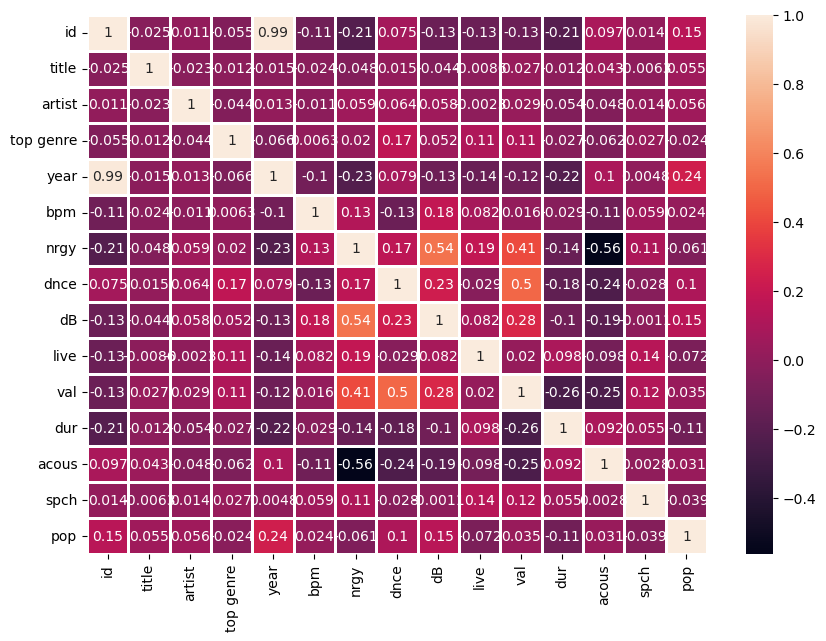

In [14]:
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(), annot=True, linewidths=2)

En el mapa de calor podem observar els atributs més correlacionats com els valors que més s'allunyen del 0.

Ara agruparem els valors de les diferents característiques per mostrar l'interaval de popularitat de cada valor:

In [15]:
df[["year",'pop']].groupby(["year"], as_index = False).mean().sort_values(by='year')

,year,pop
0,2010,5.980392
1,2011,5.698113
2,2012,6.285714
3,2013,5.985915
4,2014,5.810345
5,2015,6.000000
6,2016,5.975000
7,2017,6.430769
8,2018,6.796875
9,2019,8.000000


In [16]:
df[["dB",'pop']].groupby(["dB"], as_index = False).mean().sort_values(by='dB')

,dB,pop
0,-60,0.000000
1,-15,4.000000
2,-13,3.000000
3,-12,6.000000
4,-11,5.000000
5,-10,5.714286
6,-9,5.937500
7,-8,6.310345
8,-7,6.383721
9,-6,6.370079


In [17]:
df[["nrgy",'pop']].groupby(["nrgy"], as_index = False).mean().sort_values(by='nrgy')

,nrgy,pop
0,0,0.000000
1,4,4.000000
2,14,5.000000
3,15,6.000000
4,17,3.000000
...,...,...
72,93,6.888889
73,94,6.000000
74,95,5.428571
75,96,5.500000


 ### - Normaliztació

Ara anem a veure les distribucions dels atributs:

In [18]:
df.describe()

,id,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
count,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000
mean,302.000000,291.341625,88.927032,9.097844,2014.592040,118.545605,70.504146,64.379768,-5.578773,17.774461,52.225539,224.674959,14.326700,8.358209,6.199005
std,174.215384,168.689120,53.467393,2.293725,2.607057,24.795358,16.310664,13.378718,2.798020,13.102543,22.513020,34.130059,20.766165,7.483162,1.471839
min,1.000000,0.000000,0.000000,0.000000,2010.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,134.000000,0.000000,0.000000,0.000000
25%,151.500000,146.500000,41.000000,10.000000,2013.000000,100.000000,61.000000,57.000000,-6.000000,9.000000,35.000000,202.000000,2.000000,4.000000,6.000000
50%,302.000000,291.000000,87.000000,10.000000,2015.000000,120.000000,74.000000,66.000000,-5.000000,12.000000,52.000000,221.000000,6.000000,5.000000,6.000000
75%,452.500000,437.500000,137.000000,10.000000,2017.000000,129.000000,82.000000,73.000000,-4.000000,24.000000,69.000000,239.500000,17.000000,9.000000,7.000000
max,603.000000,583.000000,183.000000,10.000000,2019.000000,206.000000,98.000000,97.000000,-2.000000,74.000000,98.000000,424.000000,99.000000,48.000000,9.000000


Primer analitzem els atributs numèrics continus ja que tenen desviacions estàndards considerablement altes:

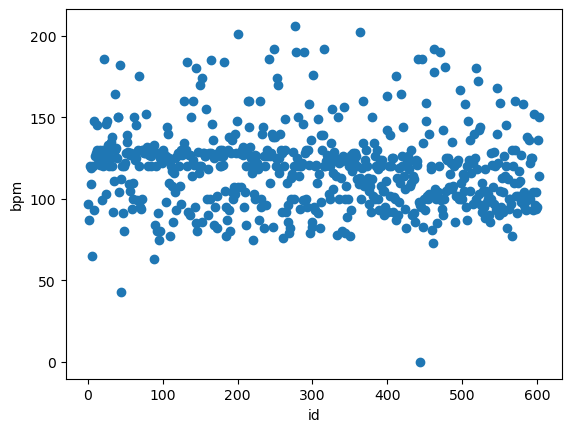

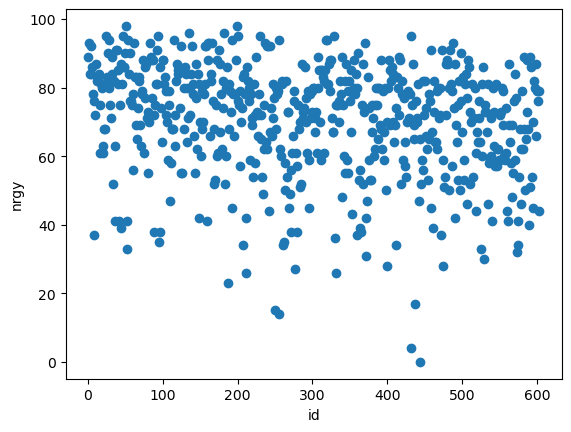

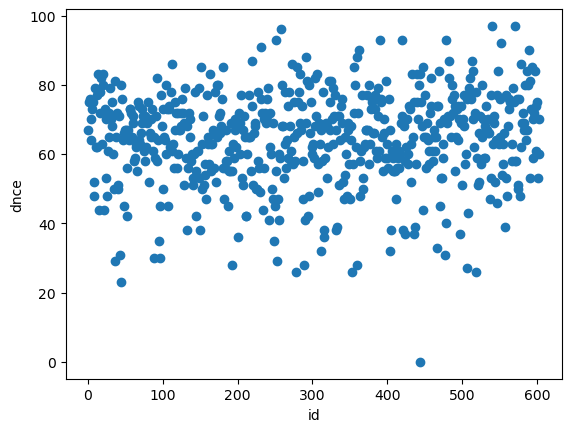

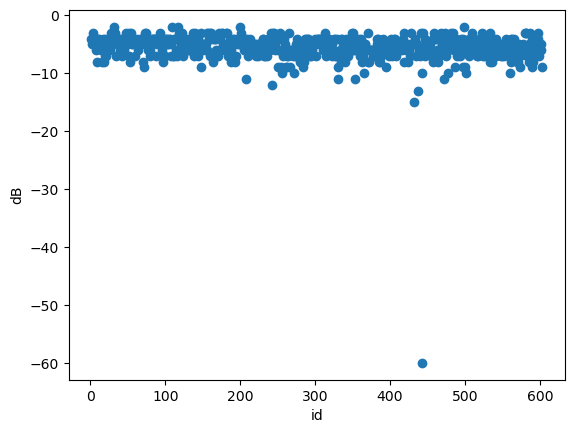

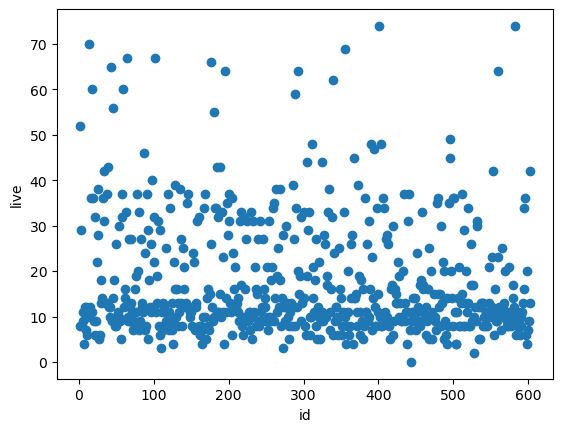

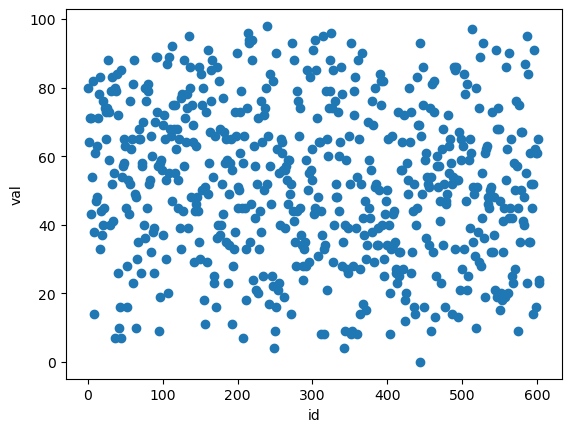

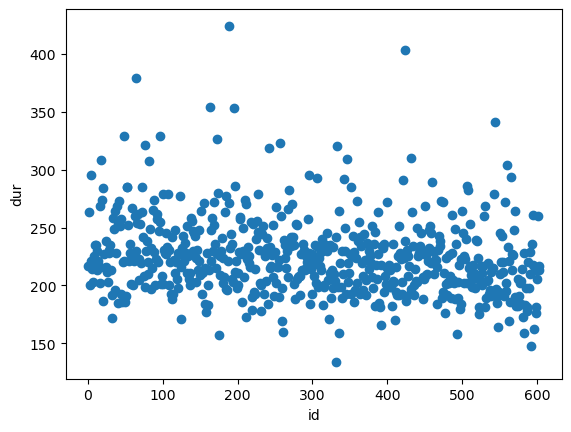

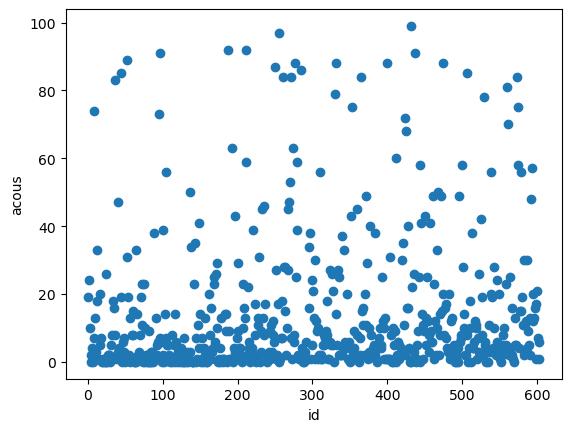

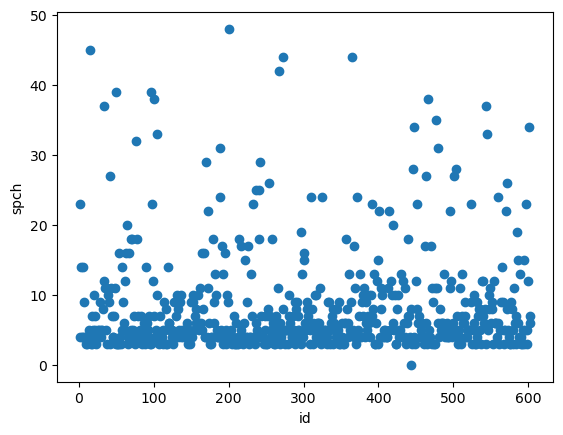

In [19]:
# Distribució de bpm
plt.scatter(df["id"],df["bpm"])
plt.xlabel("id")
plt.ylabel("bpm")
plt.show()

# Distribució de nrgy
plt.scatter(df["id"],df["nrgy"])
plt.xlabel("id")
plt.ylabel("nrgy")
plt.show()

# Distribució de dnce
plt.scatter(df["id"],df["dnce"])
plt.xlabel("id")
plt.ylabel("dnce")
plt.show()

# Distribució de dB
plt.scatter(df["id"],df["dB"])
plt.xlabel("id")
plt.ylabel("dB")
plt.show()

# Distribució de live
plt.scatter(df["id"],df["live"])
plt.xlabel("id")
plt.ylabel("live")
plt.show()

# Distribució de val
plt.scatter(df["id"],df["val"])
plt.xlabel("id")
plt.ylabel("val")
plt.show()

# Distribució de dur
plt.scatter(df["id"],df["dur"])
plt.xlabel("id")
plt.ylabel("dur")
plt.show()

# Distribució de acous
plt.scatter(df["id"],df["acous"])
plt.xlabel("id")
plt.ylabel("acous")
plt.show()

# Distribució de spch
plt.scatter(df["id"],df["spch"])
plt.xlabel("id")
plt.ylabel("spch")
plt.show()

Primer de tot, si ens fixem sembla ser que hi ha una mostra estranya la qual el seu valor resulta ser un outlier radical en la majoria de casos, sent 0. Ho comprovem:

In [20]:
print(df[df['bpm'] == 0])

      id  title  artist  top genre  year  bpm  nrgy  dnce  dB  live  val  dur  \
442  443    320       4          3  2016    0     0     0 -60     0    0  227   

     acous  spch  pop  
442      0     0    0  


Aquesta mostra és la cançó amb 'id' 443 que equival a la cançó "Million Years Ago" de l'artista Adele. Efectivament, aquesta mostra sembla ser estranya ja que l'únic atribut numèric continu que sembla ser correcte és la 'dur', així que considerem eliminar-la del nostre dataset. I tornem a mostrar la taula d'estadístiques descriptives ja que s'hauran actualitzat els mínims.

In [21]:
df = df[df['id'] != 443]

In [22]:
df.describe()

,id,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
count,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000
mean,301.765781,291.294020,89.068106,9.107973,2014.589701,118.742525,70.621262,64.486711,-5.488372,17.803987,52.312292,224.671096,14.350498,8.372093,6.209302
std,174.265217,168.825348,53.399418,2.282095,2.608592,24.339497,16.068471,13.129357,1.704657,13.093347,22.430640,34.158310,20.775203,7.481608,1.451162
min,1.000000,0.000000,0.000000,0.000000,2010.000000,43.000000,4.000000,23.000000,-15.000000,2.000000,4.000000,134.000000,0.000000,3.000000,0.000000
25%,151.250000,146.250000,41.000000,10.000000,2013.000000,100.000000,61.000000,57.000000,-6.000000,9.000000,35.000000,202.000000,2.000000,4.000000,6.000000
50%,301.500000,290.500000,87.000000,10.000000,2015.000000,120.000000,74.000000,66.000000,-5.000000,12.000000,52.000000,220.500000,6.000000,5.000000,6.000000
75%,452.750000,437.750000,137.000000,10.000000,2017.000000,129.000000,82.000000,73.000000,-4.000000,24.000000,69.000000,239.750000,17.000000,9.000000,7.000000
max,603.000000,583.000000,183.000000,10.000000,2019.000000,206.000000,98.000000,97.000000,-2.000000,74.000000,98.000000,424.000000,99.000000,48.000000,9.000000


A continuació, decidim si utilitzem un StandardScaler o un RobustScaler per normalitzar l'atribut, depenent de com siguin les distribucions mirant les gràfiques anteriors (sense tenir en compte els valors de 0 en tots els atributs, excepte 'dB' que és -60), la mitjana i els valors mínims i màxims.

- StandardScaler: La seva distribució no presenta masses outliers i els seus valors es troben concentrats al voltant de la mitjana. Atributs: 'bpm', 'nrgy', 'dnce', 'dB', i 'val'.

- RobustScaler: La seva distribució és desigual mostrant alguns outliers i valors allunyats de la mitjana. Atributs: 'live', 'dur', i 'acous'.

In [23]:
from sklearn.preprocessing import StandardScaler, RobustScaler

scaler=StandardScaler()

df[['bpm', 'nrgy', 'dnce', 'dB', 'val']]=scaler.fit_transform(df[['bpm', 'nrgy', 'dnce', 'dB', 'val']])

scaler=RobustScaler()

df[['live', 'dur', 'acous', 'spch']]=scaler.fit_transform(df[['live', 'dur', 'acous', 'spch']])

df.describe()

,id,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
count,602.000000,602.000000,602.000000,602.000000,602.000000,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,602.000000,6.020000e+02,602.000000,602.000000,602.000000,602.000000
mean,301.765781,291.294020,89.068106,9.107973,2014.589701,-7.081821e-17,-4.721214e-17,-2.301592e-16,-4.721214e-17,0.386932,5.901518e-18,0.110493,0.556700,0.674419,6.209302
std,174.265217,168.825348,53.399418,2.282095,2.608592,1.000832e+00,1.000832e+00,1.000832e+00,1.000832e+00,0.872890,1.000832e+00,0.904856,1.385014,1.496322,1.451162
min,1.000000,0.000000,0.000000,0.000000,2010.000000,-3.114506e+00,-4.149534e+00,-3.162471e+00,-5.584431e+00,-0.666667,-2.155644e+00,-2.291391,-0.400000,-0.400000,0.000000
25%,151.250000,146.250000,41.000000,10.000000,2013.000000,-7.706861e-01,-5.992645e-01,-5.707010e-01,-3.003850e-01,-0.200000,-7.724563e-01,-0.490066,-0.266667,-0.200000,6.000000
50%,301.500000,290.500000,87.000000,10.000000,2015.000000,5.170693e-02,2.104461e-01,1.153558e-01,2.867312e-01,0.000000,-1.393416e-02,0.000000,0.000000,0.000000,6.000000
75%,452.750000,437.750000,137.000000,10.000000,2017.000000,4.217838e-01,7.087296e-01,6.489555e-01,8.738474e-01,0.800000,7.445880e-01,0.509934,0.733333,0.800000,7.000000
max,603.000000,583.000000,183.000000,10.000000,2019.000000,3.587997e+00,1.705296e+00,2.478440e+00,2.048080e+00,4.133333,2.038538e+00,5.390728,6.200000,8.600000,9.000000


Ara ja tenim els nostres atributs númerics continus normalitzats. Com podem veure hem aconseguit reduir considerablement la desviació estàndard.

 ### - Equilibració de classes

Per acabar amb aquest apartat, anem a veure si la distribució del target està equilibrada.

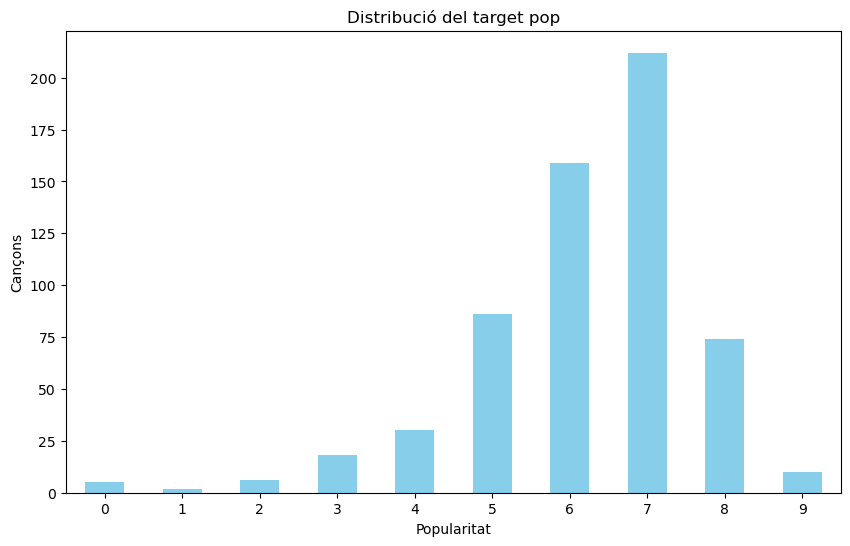

pop
0      5
1      2
2      6
3     18
4     30
5     86
6    159
7    212
8     74
9     10
Name: count, dtype: int64


In [24]:
# Agafem els valors de 'pop' ordenats
pop_counts = df['pop'].value_counts().sort_index()

plt.figure(figsize=(10,6))
pop_counts.plot(kind='bar', color='skyblue')
plt.title('Distribució del target pop')
plt.xlabel('Popularitat')
plt.ylabel('Cançons')
plt.xticks(rotation=0)
plt.show()

print(pop_counts)

Com podem veure està molt desequilibrada. Sent les classes que tenen més mostres la 6 i 7 amb 159 i 212 mostres respectivament, i les classes amb menys mostres les 0, 1, 2, 3, 4 i 9 amb 5, 2, 6, 18, 20 i 10 mostres respectivament. Així doncs, hem pensat d'aplicar una tècnica de sobremostreig utilitzant SMOTE per generar dades sintètiques. Però, donat que tenim massa poques dades per les classes del 0 al 2, hem pensat de juntar les classes per sota de 5, creant una categoria que sigui "not popular".
Així quedarien les etiquetes del target 'pop' llavors:
- 0: "not popular"
- 5: "very low pop"
- 6: "low pop"
- 7: "mid pop"
- 8: "high pop"
- 9: "very high pop"

In [25]:
# Executar aquesta línea de codi per solucionar problemes de compatibilitat entre scikit-learn i imbalanced-learn
# pip install --upgrade scikit-learn imbalanced-learn

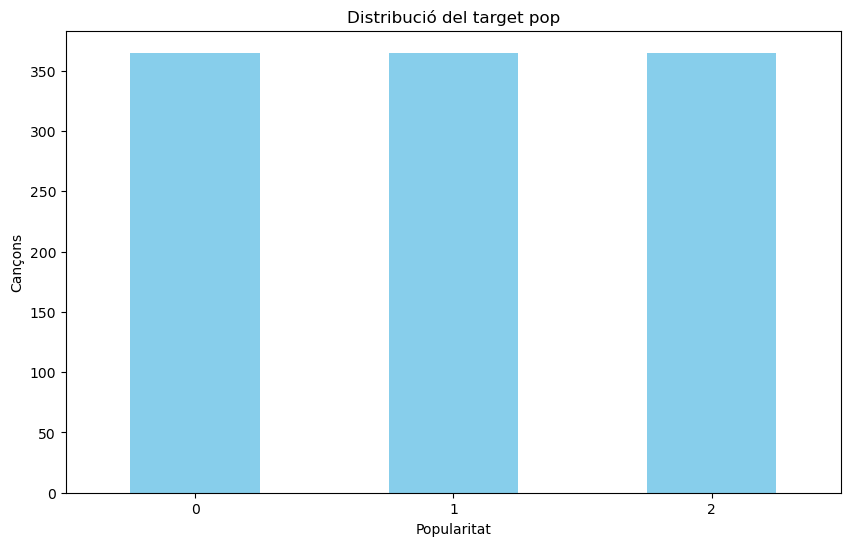

pop
0    365
1    365
2    365
Name: count, dtype: int64


In [26]:
# Combinem les classes 0, 1, 2, 3 i 4 en una sola categoria
df['pop'] = df['pop'].replace([0, 1, 2, 3, 4], 0)
df['pop'] = df['pop'].replace([5,6,7],1)
df['pop'] = df['pop'].replace([8,9],2)

# En aquest punt ja podem separar el dataset en el conjunt de cracterístiques X i el conjunt de target y.
X=df.drop('pop',axis=1)
y=df['pop']
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

smote = SMOTE(random_state=42)
x_train,y_train = smote.fit_resample(x_train, y_train)

df_resampled = pd.DataFrame(x_train, columns=X.columns)
df_resampled['pop'] = y_train

# Agafem els valors de 'pop' ordenats
pop_counts = df_resampled['pop'].value_counts().sort_index()

plt.figure(figsize=(10,6))
pop_counts.plot(kind='bar', color='skyblue')
plt.title('Distribució del target pop')
plt.xlabel('Popularitat')
plt.ylabel('Cançons')
plt.xticks(rotation=0)
plt.show()

print(pop_counts)

Ara ja tenim les dades balancejades.

## 2. Metric Selection

### - Selecció de la millor mètrica

Abans de res descartem els atributs que no volem considerar pel nostre model.

In [27]:
# Aquí descartar el id i potser el títol i els artistes
df_resampled = df_resampled.drop(['id', 'artist', 'title'], axis=1)
# També potser hauriem de considerar codificar l'atribut 'year' (2010: 0, 2011: 1, 2012: 2, ..., 2019: 9)
df_resampled['year'] = df_resampled['year'] - 2010

Ara separarem les dades en conjunts d'entrenament i de test. Començarem per entrenar un classificador lineal (regressió logística):

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, roc_curve,roc_auc_score, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve 

# Per mostrar l'ùs d'aquestes funcions entrenarem un regresor logistic
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(x_train, y_train)

E:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
E:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

Funcio per mostrar diferents metriques així com la matriu de confusió.

In [29]:
# Donat un model i un split del dataset, aquesta funció permet visualitzar varis valors (mètriques) de rendiment (performance):
# - Accuracy
# - Precission
# - Recall (altrament dit: Sensitivity o True Positive Rate)
# - Confusion Matrix
# FONT: Coneixement, Raonament i Incertesa https://e-aules.uab.cat/2024-25/course/view.php?id=2032

def show_performance(x, y, model, average='binary', plot_title='confusion matrix'):

    predictions = model.predict(x)
    acc = accuracy_score(y, predictions)
    prec = precision_score(y, predictions, average=average)
    rec = recall_score(y, predictions, average=average)
    f1 = (2*prec*rec)/(prec+rec)
    conf_mat = confusion_matrix(y, predictions)

    print('-' * 25)
    print('>>> Rendiment del model:')
    print(f'- Accuracy: {round(acc, 3)}')
    print(f'- Precision: {round(prec, 3)}')
    print(f'- Recall (Sensitivity, TPR): {round(rec, 3)}')
    print(f'- F1: {round(f1, 3)}')
    print('-' * 25)
      
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)  
    disp.plot()  
    plt.title(plot_title)
    plt.show() 

-------------------------
>>> Rendiment del model:
- Accuracy: 0.488
- Precision: 0.372
- Recall (Sensitivity, TPR): 0.398
- F1: 0.384
-------------------------


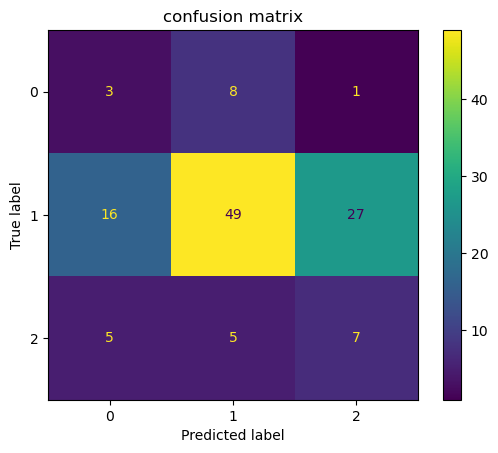

In [30]:
show_performance(x_test, y_test, model, average='macro')

### - Visualització de ROC/AUC

Funcio per mostrar la corva ROC, amb yellowbrick podem mostrar amb facilitat les corbes ROC de datasets multiclasse

In [31]:
from sklearn.preprocessing import LabelBinarizer

def mostra_corva_roc(X_test, y_test, model):
    lb = LabelBinarizer()
    y_test_bin = lb.fit_transform(y_test)

    y_score = model.predict_proba(X_test)

    fpr = {}
    tpr = {}
    roc_auc = {}
    n_classes = y_test_bin.shape[1]

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Classe {lb.classes_[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de falsos positius')
    plt.ylabel('Taxa de veritables positius')
    plt.title('Corba ROC Multiclasse')
    plt.legend(loc='lower right')
    plt.show()


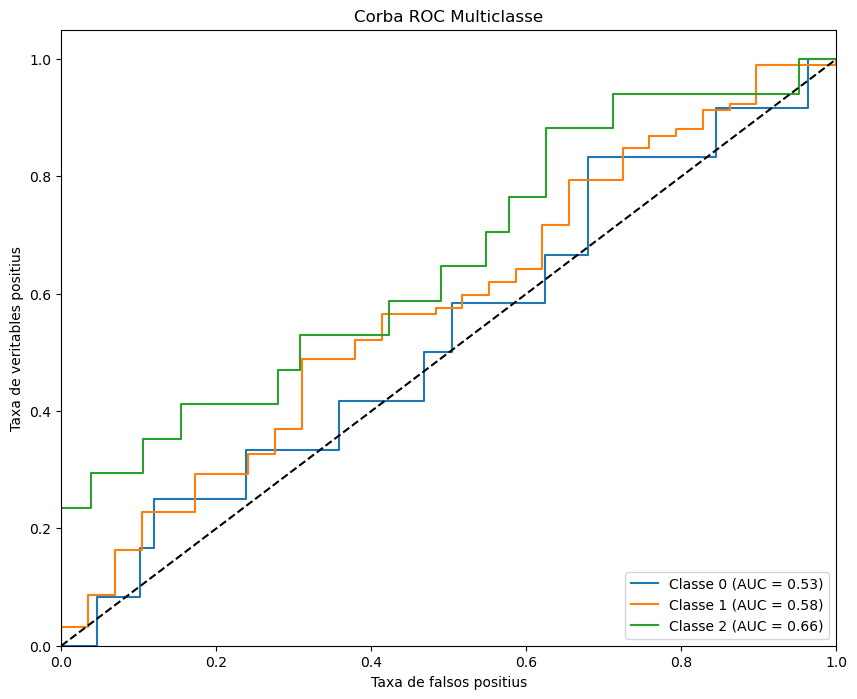

In [32]:
mostra_corva_roc(x_test, y_test, model)

Funció per veure si hi ha overfitting amb la corva d'aprenentatge

E:\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "E:\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\anaconda\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "E:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1301, in fit
    raise ValueError(
ValueError: This solver needs samples of at l

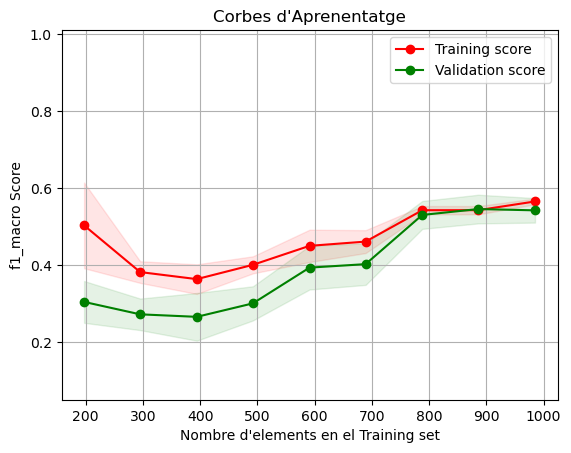

In [33]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(train_sizes, train_scores, val_scores, scoring, ylim=None):
        
    #train_sizes, train_scores, val_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    plt.figure()
    plt.title('Corbes d\'Aprenentatge')
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Nombre d\'elements en el Training set')
    plt.ylabel(f'{scoring} Score')
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label='Validation score')
    plt.legend(loc='best')
    plt.show()

train_sizes, train_scores, val_scores = learning_curve(model, x_train, y_train, cv=10, scoring="f1_macro", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
plot_learning_curve(train_sizes, train_scores, val_scores, scoring="f1_macro",ylim=(0.05, 1.01))  

#### Tenint en compte que hem de classificar un dataset multiclasse perfectament equilibrat, i que no hi ha cap classe que tingui més importancia respecte a les altres, la mètrica que ens serveix millor per evaluar el rendiment del model serà la "Accuracy"

## 3. Model Selection i Crossvalidation

·Per a la classificació hem considerat els següents models:

- Regressió Logístic amb estrategia One vs Rest: És un model lineal fàcil d'interpretar, ràpid i eficient per problemes multiclasse com el nostre. Creiem que la majoria relacions del nostre dataset no són lineals, per tant ens serà interessant comparar l'eficiència d'un model lineal com aquest amb altres models no lineals.

- Arbre de desició: Un altre model simple i eficient per a datasets multiclasse. A difereicia del regressor logístic, els arbres de desició sol adaptarse per trobar relacions no lineals, per tant pot ser interesant utilitzar-ho.

- KNN: L'hem seleccionat per la seva senzilleça i per ser memorístic (no li cal entrenament).

- Random Forest: En cas que les relacions del nostre dataset no siguin lineals, aquest potent classificador és capaç d'ajustar-se a característiques no lineals i en situacions de falta de dades. També l'hem triat per veure la diferència d'un mètode "ensamble" en contraposició als mètodes simples. 

- AdaBoost: Un altre classificador amb metode "ensamble" per poder comparar l'eficiencia d'aquest respecte al Random Forest.

- Xarxes Neuronals Artificials: No hi ha cap dubte que les xarxes neuronals són una eina excepcional en l'àmbit de l'Aprenentatge Computacional. Aquest tipus de model s'utilitza en altres datasets, on les relacions entre les característiques i el target són molt més complexes, però ens fa curiositat saber com es comportarà en aquest dataset específic.

### - Selecció del millor model

E:\anaconda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
E:\anaconda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
E:\anaconda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
E:\anaconda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
E:\anaconda\Lib\site-packages\sklearn\ensemble\_weight_boosting.

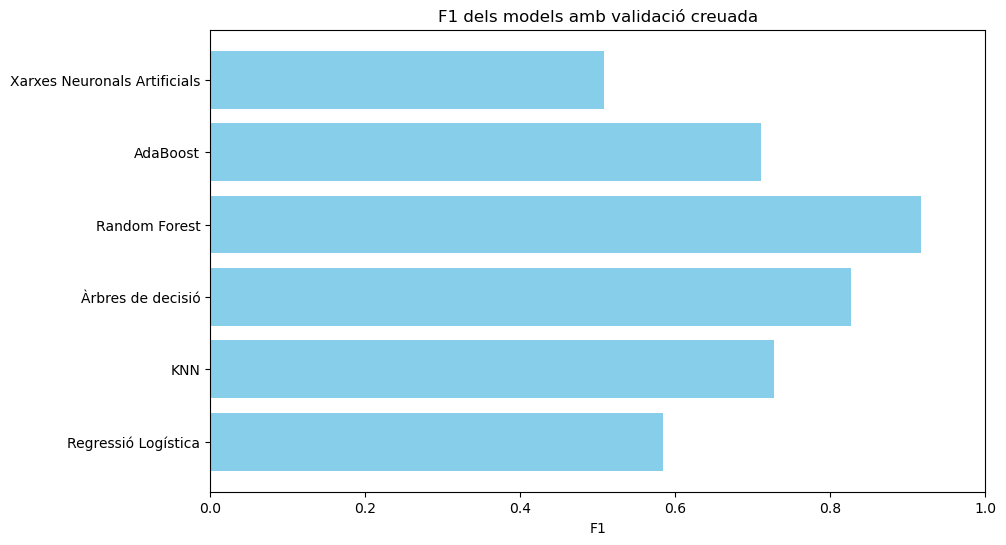

El millor model és: Random Forest amb un accuracy mitjà de:  0.9172

{'Regressió Logística': 0.5839879773412671, 'KNN': 0.7275240711797762, 'Àrbres de decisió': 0.8273459785337938, 'Random Forest': 0.9172213194480164, 'AdaBoost': 0.7114284039272114, 'Xarxes Neuronals Artificials': 0.508315426783028}


In [34]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)


x_trainSubset, x_validation, y_trainSubset, y_validation = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

models = {
    "Regressió Logística": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "Àrbres de decisió": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Xarxes Neuronals Artificials": MLPClassifier(max_iter=1000)
}

results = {}

for model_name, model in models.items():
    cv_scores = cross_val_score(model,x_trainSubset,y_trainSubset,cv=10,scoring="f1_macro")
    results[model_name] = cv_scores.mean()
    
plt.figure(figsize=(10, 6))
plt.barh(list(results.keys()), list(results.values()), color='skyblue')
plt.xlabel('F1')
plt.title('F1 dels models amb validació creuada')
plt.xlim(0, 1)
plt.show()


best_model = max(results, key=results.get)
print(f"El millor model és: {best_model} amb un f1 mitjà de:  {results[best_model]:.4f}\n")
print(results)

### - Cerca d'hiperparàmetres

In [35]:
# ELIMINEM EL MODEL AdaBoost

del(models["AdaBoost"])

In [36]:
from sklearn.model_selection import GridSearchCV
import time

# DEFINIM ELS HIPERPARÀMETRES DE CADA MODEL DELS QUALS VOLEM BUSCAR EL VALOR ÒPTIM

param_grids = {
    "Regressió Logística": {
        'C': [0.1, 1, 10, 100, 200],
        'solver': ['liblinear', 'lbfgs']
    },
    "KNN": {
        'n_neighbors': [6,7,8,9,10,11,12],
        'weights': ['uniform', 'distance'],
        'metric': ['minkowski', 'euclidean', 'manhattan'],
        'p' : [1,2]
    },
    "Àrbres de decisió": {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 10, 20],
        'splitter' : ['best', 'random'],
        'class_weight' : [None, 'balanced']
    },
    "Random Forest": {
        'n_estimators': [100, 200, 300, 350],
        'max_depth': [None, 10, 20],
        'criterion': ['gini', 'entropy']
    },
    "Xarxes Neuronals Artificials": {
        'hidden_layer_sizes': [(50,), (100,), (50, 30), (10, 20, 30)],
        'solver': ['adam', 'lbfgs'],
        'alpha': [0.0001, 0.001, 0.01, 0.1]
    }
}

millors_models={}
maximAccuracy = 0
for model_name, model in models.items():
    print(f"Optimitzant el següent model: {model_name}")
    grid_search=GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        scoring="f1_macro",
        cv=10,
        n_jobs=-1 
    )
    tim=time.time()
    grid_search.fit(x_train, y_train)
    millors_models[model_name]=grid_search.best_estimator_
    print(f"Millor F1 de {model_name}: {grid_search.best_score_}\n")
    print(f"Millors paràmetres de {model_name}: {grid_search.best_params_}\n")
    print(f"Temps de búsqueda d'Hiperparàmetres: {time.time()-tim}\n")
    if grid_search.best_score_ > maximAccuracy:
        millorModel = grid_search
        maximAccuracy = grid_search.best_score_

Optimitzant el següent model: Regressió Logística
Millor Accuracy de Regressió Logística: 0.5800098749908287

Millors paràmetres de Regressió Logística: {'C': 100, 'solver': 'liblinear'}

Temps de búsqueda d'Hiperparàmetres: 0.7059640884399414

Optimitzant el següent model: KNN
Millor Accuracy de KNN: 0.818352618354964

Millors paràmetres de KNN: {'metric': 'minkowski', 'n_neighbors': 6, 'p': 1, 'weights': 'distance'}

Temps de búsqueda d'Hiperparàmetres: 2.5586800575256348

Optimitzant el següent model: Àrbres de decisió
Millor Accuracy de Àrbres de decisió: 0.8395026865572153

Millors paràmetres de Àrbres de decisió: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2, 'splitter': 'best'}

Temps de búsqueda d'Hiperparàmetres: 3.3081493377685547

Optimitzant el següent model: Random Forest
Millor Accuracy de Random Forest: 0.9308454052285153

Millors paràmetres de Random Forest: {'criterion': 'gini', 'max_depth': None, 'n_estimators': 300}

Tem

Visualitzant Overfitting del següent model: Regressió Logística


E:\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "E:\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\anaconda\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "E:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1276, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
   

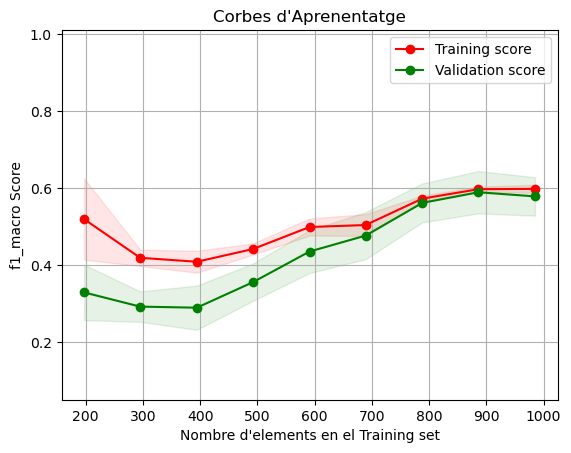

Visualitzant Overfitting del següent model: KNN


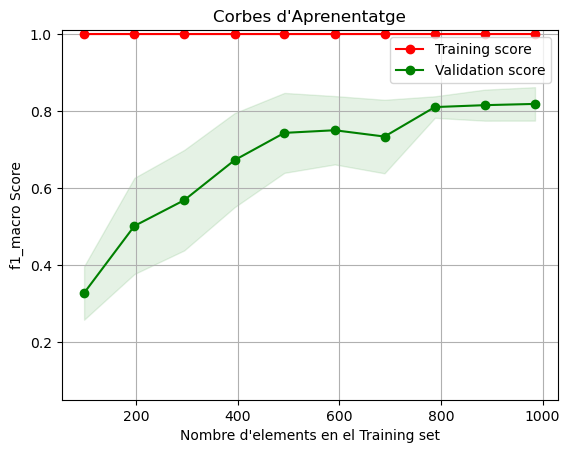

Visualitzant Overfitting del següent model: Àrbres de decisió


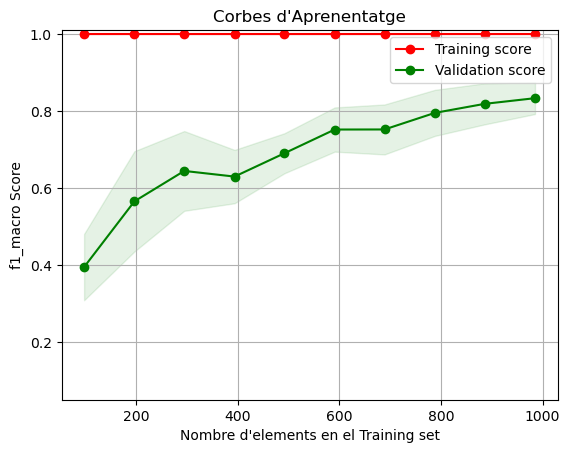

Visualitzant Overfitting del següent model: Random Forest


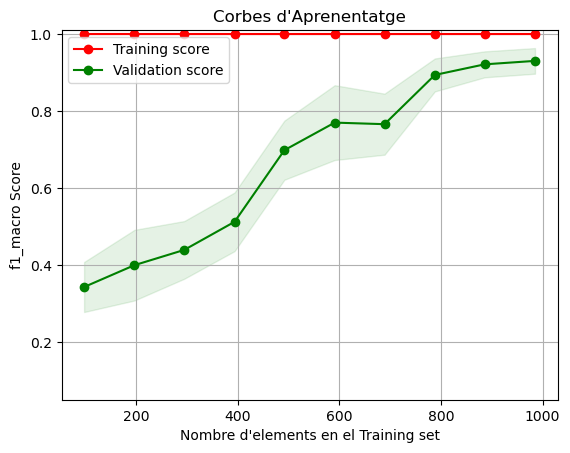

Visualitzant Overfitting del següent model: Xarxes Neuronals Artificials


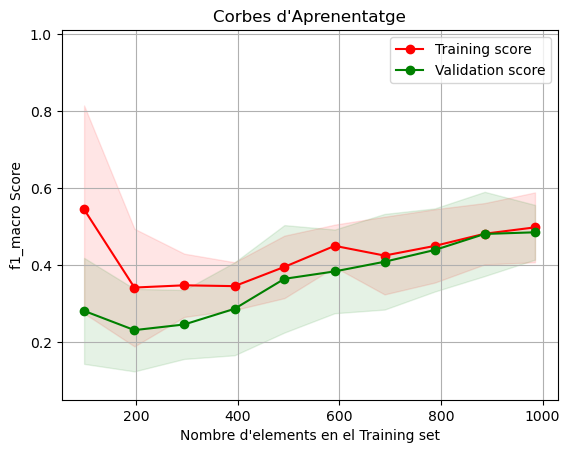

In [37]:
for model_name, model in millors_models.items():
    print(f"Visualitzant Overfitting del següent model: {model_name}")
    train_sizes, train_scores, val_scores = learning_curve(model, x_train, y_train, cv=10, scoring="f1_macro", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
    plot_learning_curve(train_sizes, train_scores, val_scores, scoring="f1_macro",ylim=(0.05, 1.01))

Visualitzant Overfitting del següent model: Regressió Logística


E:\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "E:\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\anaconda\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "E:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1276, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
   

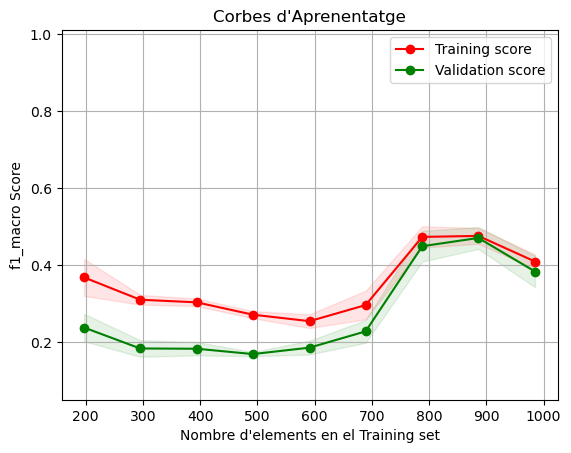

Visualitzant Overfitting del següent model: KNN


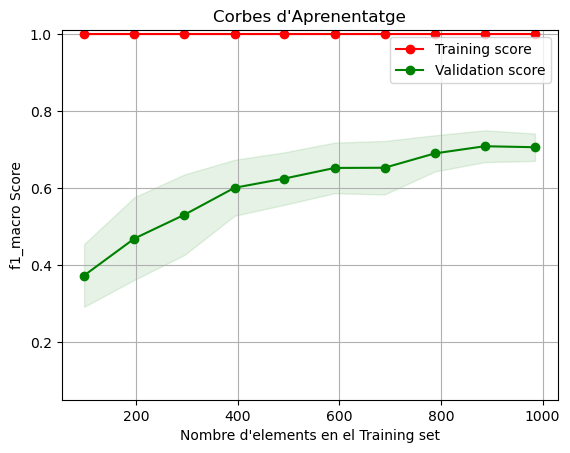

Visualitzant Overfitting del següent model: Àrbres de decisió


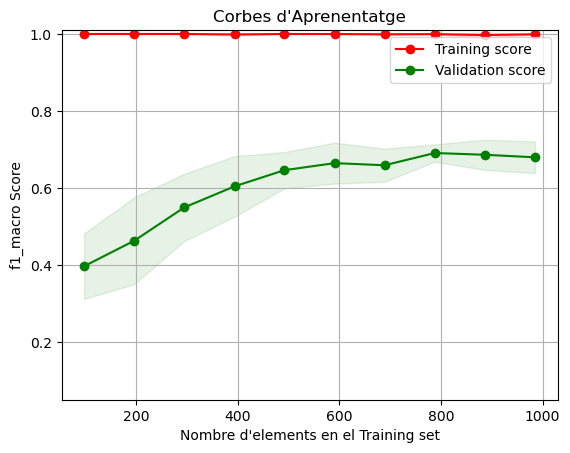

Visualitzant Overfitting del següent model: Random Forest


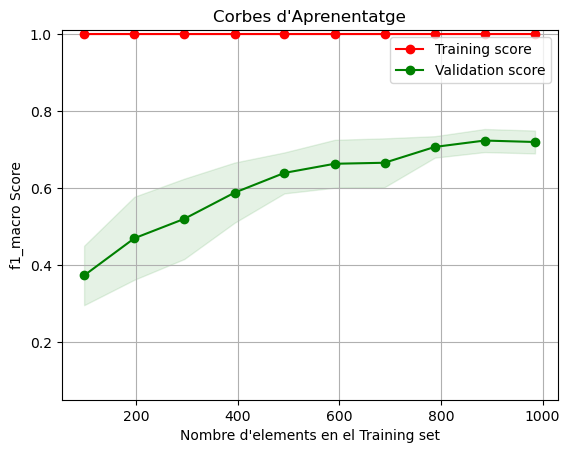

Visualitzant Overfitting del següent model: Xarxes Neuronals Artificials


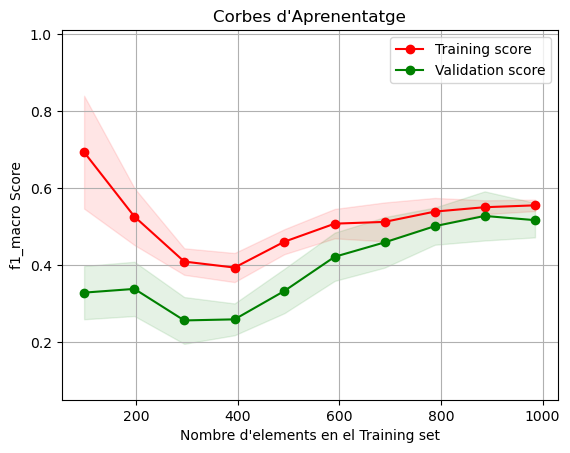

In [38]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.80)
x_trainPCA = pca.fit_transform(x_train)
for model_name, model in millors_models.items():
    print(f"Visualitzant Overfitting del següent model: {model_name}")
    train_sizes, train_scores, val_scores = learning_curve(model, x_trainPCA, y_train, cv=10, scoring="f1_macro", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
    plot_learning_curve(train_sizes, train_scores, val_scores, scoring="f1_macro",ylim=(0.05, 1.01))

## 4. Anàlisi Final

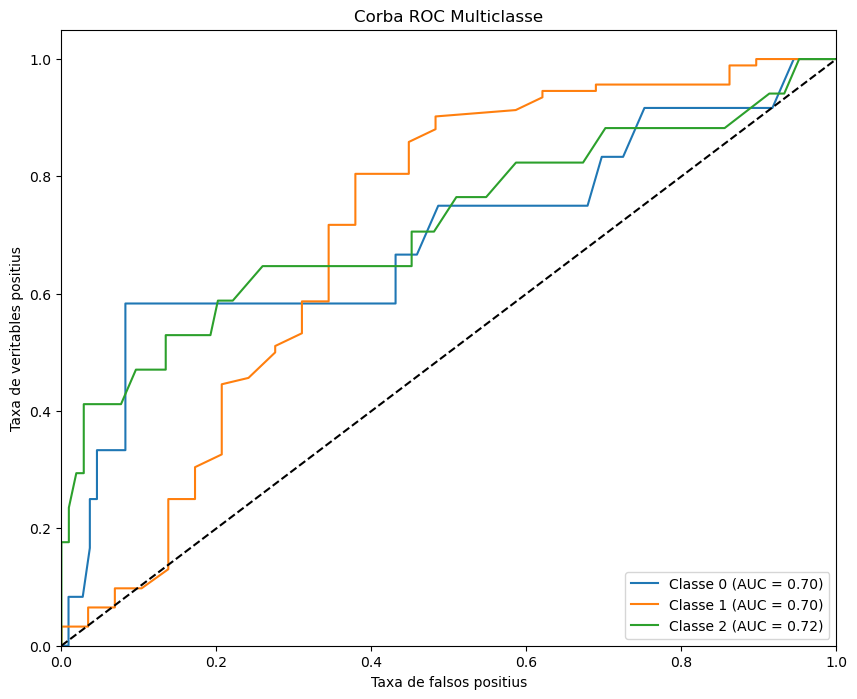

In [39]:
#modelFinal = RandomForestClassifier(n_estimators=300, criterion='gini', max_depth=None)
modelFinal = millorModel
modelFinal.fit(x_train, y_train)
mostra_corva_roc(x_test, y_test, modelFinal)

-------------------------
>>> Rendiment del model:
- Accuracy: 0.769
- Precision: 0.596
- Recall (Sensitivity, TPR): 0.545
- F1: 0.57
-------------------------


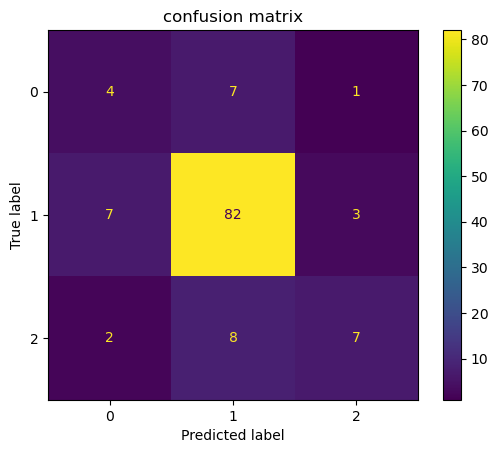

In [40]:
show_performance(x_test, y_test, modelFinal, average='macro')